In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the directory path where the CSV files are stored
csv_directory = 'data/'

# Read and concatenate CSV files
dataframes = []
for file in os.listdir(csv_directory):
    if file.endswith('.csv'):
        file_path = os.path.join(csv_directory, file)
        temp_df = pd.read_csv(file_path)
        temp_df['file_name'] = file
        dataframes.append(temp_df)

# Combine dataframes into a single dataframe
combined_df = pd.concat(dataframes, ignore_index=True)

# Save the combined dataframe to a new CSV file if needed
combined_df.to_csv('combined_dataframe.csv', index=False)

In [12]:
# Extract city and time from file_name column
combined_df['city'] = combined_df['file_name'].apply(lambda x: x.split('_')[0])
combined_df['time'] = combined_df['file_name'].apply(lambda x: 1 if x.split('_')[1] == 'weekends' else 0)
combined_df.drop('file_name', axis=1, inplace=True)

# Rename realSum column to price
combined_df.rename(columns={'realSum': 'price'}, inplace=True)

# RO
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

    return df
columns_to_remove_outliers = ['price']
combined_df = remove_outliers(combined_df, columns_to_remove_outliers)

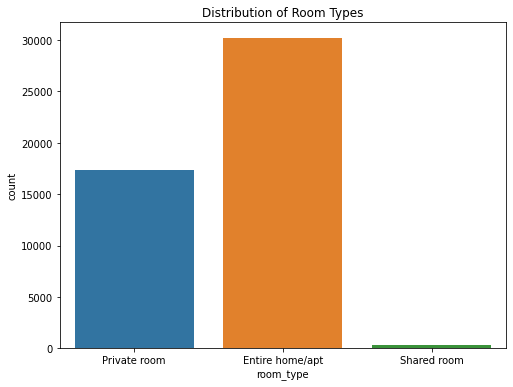

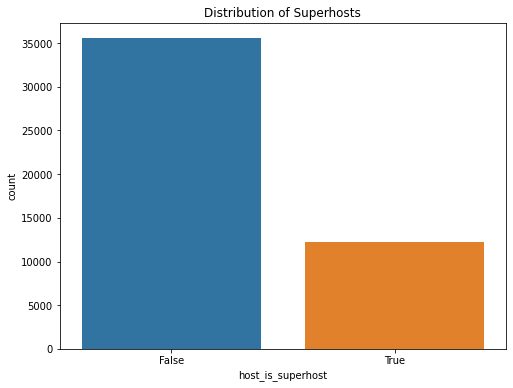

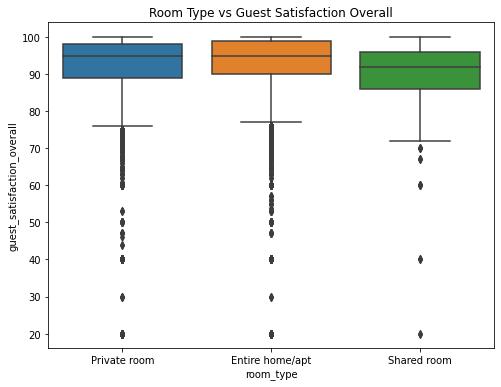

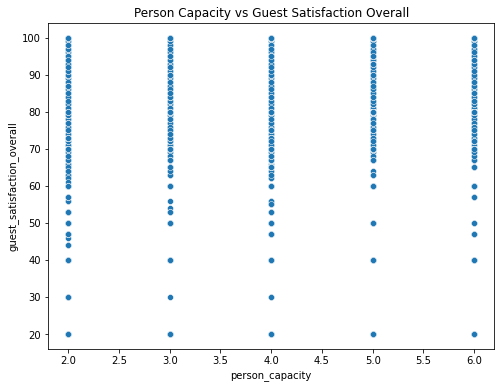

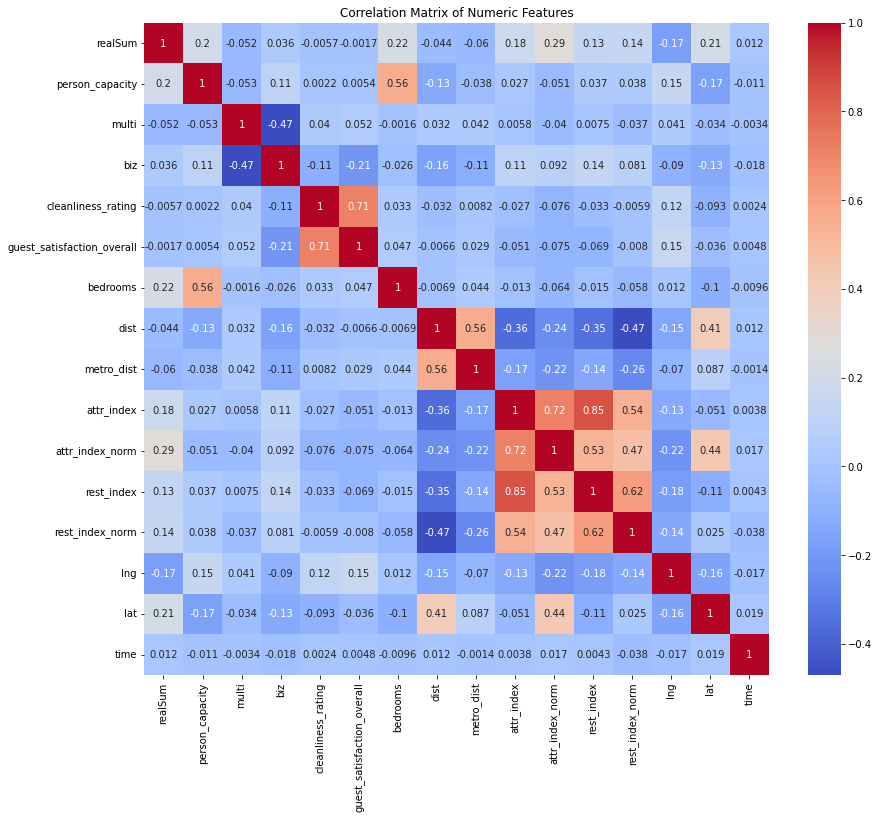

In [13]:
# EDA graphs and explanations

# 1. Distribution of room types
plt.figure(figsize=(8, 6))
sns.countplot(data=combined_df, x='room_type')
plt.title('Distribution of Room Types')
plt.show()
# Explanation: This graph shows the count of different room types in the dataset.

# 2. Distribution of host_is_superhost
plt.figure(figsize=(8, 6))
sns.countplot(data=combined_df, x='host_is_superhost')
plt.title('Distribution of Superhosts')
plt.show()
# Explanation: This graph shows the number of superhosts and non-superhosts in the dataset.

# 3. Relationship between room type and guest satisfaction overall
plt.figure(figsize=(8, 6))
sns.boxplot(data=combined_df, x='room_type', y='guest_satisfaction_overall')
plt.title('Room Type vs Guest Satisfaction Overall')
plt.show()
# Explanation: This graph shows the relationship between room types and guest satisfaction ratings.

# 4. Relationship between person capacity and guest satisfaction overall
plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_df, x='person_capacity', y='guest_satisfaction_overall')
plt.title('Person Capacity vs Guest Satisfaction Overall')
plt.show()
# Explanation: This graph shows the relationship between person capacity and guest satisfaction ratings.

# 5. Correlation matrix of numeric features
numeric_features = combined_df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = combined_df[numeric_features].corr()
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()
# Explanation: This heatmap shows the correlation between different numeric features in the dataset.


## Modle 1

In [64]:
import torch
import torch.nn as nn

class PricePredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(PricePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

input_size = X.shape[1]  # Number of input features
hidden_size1 = 128  # Number of hidden units in the first hidden layer
hidden_size2 = 64  # Number of hidden units in the second hidden layer
output_size = 1  # Number of output units (1 for price prediction)
model = PricePredictionModel(input_size, hidden_size1, hidden_size2, output_size)

In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# Load your data into a DataFrame
# df = pd.read_csv('your_data.csv')

# One-hot encode categorical features
df = pd.get_dummies(combined_df, columns=['room_type', 'room_shared', 'room_private', 'host_is_superhost', 'city'])


# Preprocess the data
X = df.drop('price', axis=1).values  # Features
y = df['price'].values.reshape(-1, 1)  # Targets

# Normalize or standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create DataLoaders for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [66]:
import torch.optim as optim

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to training mode
model.train()

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0.0
    
    for batch_idx, (features, targets) in enumerate(train_loader):
        features, targets = features.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/10], Loss: 10615.2062
Epoch [2/10], Loss: 4581.7214
Epoch [3/10], Loss: 4483.6157
Epoch [4/10], Loss: 4443.5953
Epoch [5/10], Loss: 4411.1886
Epoch [6/10], Loss: 4378.5533
Epoch [7/10], Loss: 4354.5434
Epoch [8/10], Loss: 4335.0920
Epoch [9/10], Loss: 4305.2564
Epoch [10/10], Loss: 4301.0775


## Model 2

In [60]:
import torch
import torch.nn as nn

class PricePredictionModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate, output_size):
        super(PricePredictionModel, self).__init__()

        layers = []

        # Add the first hidden layer and batch normalization
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.BatchNorm1d(hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate))

        # Add the remaining hidden layers, batch normalization, and dropout
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.BatchNorm1d(hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

        # Add the output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader

# One-hot encode categorical features
df = pd.get_dummies(combined_df, columns=['room_type', 'room_shared', 'room_private', 'host_is_superhost', 'city'])

# Preprocess the data
X = df.drop('price', axis=1).values  # Features
y = df['price'].values.reshape(-1, 1)  # Targets

# Normalize or standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create DataLoaders for training and validation sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [62]:
input_size = X.shape[1]  # Number of input features
hidden_sizes = [256, 128, 64]  # Number of hidden units in each hidden layer
dropout_rate = 0.5  # Dropout rate for regularization
output_size = 1  # Number of output units (1 for price prediction)

model = PricePredictionModel(input_size, hidden_sizes, dropout_rate, output_size)

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Prepare the dataset and DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    
    for batch_idx, (features, targets) in enumerate(train_loader):
        features, targets = features.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    
    # Validate the model
    model.eval()
    epoch_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (features, targets) in enumerate(val_loader):
            features, targets = features.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(features)
            loss = criterion(outputs, targets)
            
            epoch_val_loss += loss.item()

    epoch_val_loss /= len(val_loader)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")

Epoch [1/100], Train Loss: 40321.8797, Validation Loss: 14002.2533
Epoch [2/100], Train Loss: 8976.1298, Validation Loss: 5233.4515
Epoch [3/100], Train Loss: 6559.4029, Validation Loss: 4724.1842
Epoch [4/100], Train Loss: 6386.1204, Validation Loss: 4665.6189
Epoch [5/100], Train Loss: 6306.8887, Validation Loss: 4619.7254
Epoch [6/100], Train Loss: 6231.5870, Validation Loss: 4642.1714
Epoch [7/100], Train Loss: 6100.6735, Validation Loss: 4658.7875
Epoch [8/100], Train Loss: 6099.9900, Validation Loss: 4715.5756
Epoch [9/100], Train Loss: 5980.0286, Validation Loss: 4736.5435
Epoch [10/100], Train Loss: 6035.5869, Validation Loss: 4511.7445
Epoch [11/100], Train Loss: 5919.7901, Validation Loss: 4489.8992
Epoch [12/100], Train Loss: 5965.0821, Validation Loss: 4546.6823
Epoch [13/100], Train Loss: 5970.8653, Validation Loss: 4628.9204
Epoch [14/100], Train Loss: 5963.1529, Validation Loss: 4755.6912
Epoch [15/100], Train Loss: 5904.9257, Validation Loss: 4645.6866
Epoch [16/100], T